## House Price Predictions
Different variables come into play in appraising a house, such as the number of bedrooms, square footage, location, and much more. So, our task here is to build a machine learning model to make reasonably accurate predictions in terms of pricing houses. It would be an opportunity for those in real estate to gain more visibility on the market as a whole. In doing so, this notebook will offer a user-friendly explanation through every step using LIME (Local Interpretable Model-agnostic Explanations) principles.

## Table of Contents
1. Environment set-up
    * Importing Libraries
    * Loading the data
    
2. Initial Diagnostics
    * Glimpse
    * Descriptive Statistics
    * Target Variable Analysis
    * Predictors Analysis
    
3. Data Processing
    * Basic cleanup
    * Missing Values - Imputation
    * Outliers Detection
    
4. Inquiry Exploration
    * Does bigger means pricier houses?
    * Where is the real estate hotspot?
    * Which miscellaneous feature add the most value?
    
5. Feature Engineering
    * Outliers - Feature Scaling
    * Categorical Encoding
    * Datetime Variables
    
6. Correlation Analysis

7. Machine Learning set-up

8. Machine Learning - Model Building
    * Simple Models
    * Ensemble Methods

9. Hyperparameter Tuning

10. Final Submission

# 1. Environment Set-up

In [1]:
## Importing Libraries
import warnings
warnings.filterwarnings("ignore")

#Set seed
import random
random.seed(1234)

# Time function
import time

# Regex
import re

# Statiscal methods
from math import sqrt
from scipy import stats

# Manipulating & Visualizing Data
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.impute import SimpleImputer as imp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)})

# Feature Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

# Categorical Encoding
import category_encoders as ce

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# Dimensionality Reduction
from sklearn.decomposition import PCA, TruncatedSVD

# ML Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR

# Ensemble Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Performance metrics
import sklearn.metrics as skm

In [2]:
## Loading the dataset
raw_data = pd.read_csv("/Users/Graduate/Desktop/ds_proj_data/house_price/train.csv")
raw_data.set_index('Id', inplace=True)
raw_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 2. Initial Diagnostics

In [3]:
## Glimpse of the data
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

**Takeaway:** From the glimpse above, we could already draw some observations. 
* Our dataset comprises 1460 rows and 80 columns, making it relatively small, so we would not expect the training process o to be as computationally intensive.
* For null values, most columns appear to have no missing values, while null values make up 80% for some of those variables. It indicates that we shall proceed with data cleaning and tidying before doing any statistical analysis or machine learning. 
* In terms of variable type, we have mostly int64, float64, and object. Though 'object' can indicate text or categorical, we will need to investigate further in feature engineering.

In [4]:
## Descriptive Statistics
raw_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**Takeaway:** For all 80 variables, the table above captures the basic descriptive statistics showing things like mean, standard deviation, min, max, etc. Commenting on each variable would bring little value to our overall analysis, and so we will zoom on the target variable 'SalePrice'.

In [5]:
# Stats for the target variable
raw_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

**Takeaway:** The count indicates no null values in the column. The houses in the dataset vary from ~USD34.9k to ~USD755k, with a mean value of ~USD180k. With the standard deviation at ~USD79k, it appears that prices fluctuate pretty significantly, or we may potentially have houses with exorbitant prices (outliers) skewing the data. We will create a histogram to look at the distribution more closely.

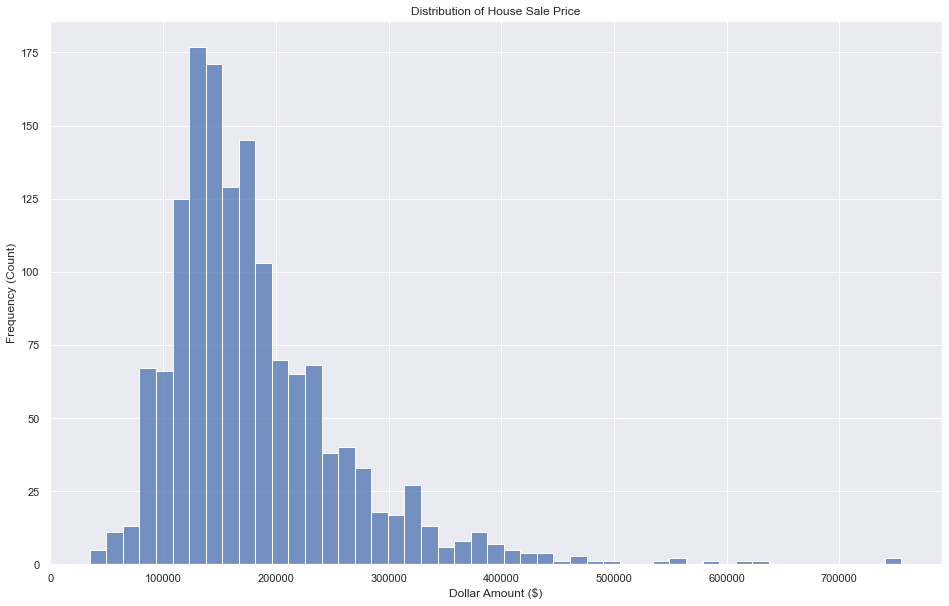

In [6]:
## Feature Variable Analysis
sns.histplot(data=raw_data, x='SalePrice')
plt.xlabel("Dollar Amount ($)")
plt.ylabel("Frequency (Count)")
plt.title("Distribution of House Sale Price")
plt.show()

**Takeaway:** From the histogram above, we can deduct that house sale prices in this dataset have a right-skewed distribution with outliers on the upper end, indicating luxury houses with higher price points. However, most houses appear to fall between ~USD100k and ~USD300k, relatively consistent with real estate markets in the United States.

# 3. Data Processing

## Basic cleanup

In [7]:
## Simple processing steps
def basic_processing(data, col_drop = [], col_rename = {"SalePrice": "target"}):
    """ Basic data processing: drop/rename columns, remove duplicate(s)
    
    Parameters
    ----------
    data : dataframe
        A dataset
    col_drop : list
        A list of column names to drop
    col_rename : dict
        A dictionary pairing the old and new column names desired

    Returns
    -------
    data
        a modified dataframe
    """ 
    #Drop the 'Serial No.' column
    if len(col_drop) > 0:
        data.drop(col_drop, axis=1, inplace=True)

    # Renaming the target variable and one predictor
    if col_rename:
        data.rename(columns=col_rename, inplace=True)
    
    # Removing any Duplicate Observations if any
    data.drop_duplicates(keep='first', inplace=True)
    return data

In [8]:
df = basic_processing(raw_data)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,target
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Note:** In data science, imperfect information is all we have so, there is always doubt on data quality of which, a recurrent issue is **missing values**. One could attempt collecting more data, delete the missing value, or proceed by imputation. Imputation methods offre replacement strategies by leveraging statistical measures like mean, mode, or median. More information [here](https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/).

## Missing Values - Imputation

In [9]:
# Identify missing values and dealing with them if present
def identify_missing_val(data):
    """ Identify missing/na values
    
    Parameters
    ----------
    data : dataframe
        A dataset

    Returns
    -------
    data
        a dataframe with no missing values 
        either after imputation or original format
    """
    
    # Count number of missing values 
    sum_na = data.isnull().sum().sum()
    print("%d null/na values found in the dataset." % sum_na)
    
    # Only visualize if missing values present
    if sum_na > 0: 
        plt.figure(figsize=(10,6))
        sns.heatmap(df.isna().transpose(),
                    cmap="YlGnBu",
                    cbar_kws={'label': 'Missing Data'})
        plt.xlabel("Features")
        plt.ylabel("Observations")
        plt.show()
        
        # Proceeding in imputing the dataset with missing values
        null_cols = data.columns[data.isnull().any()].tolist()
        print('Those columns have missing values in those count and proportions:')
        for i in null_cols:
            col_null = data[i].isnull().sum()
            per_null = col_null / len(df[i])
            print("  - {}: {} ({:.2%})".format(i, col_null, per_null))
        #print(*null_cols, sep = "\n") 
    else:
        print("- No action needed")
        pass
    return data

6965 null/na values found in the dataset.


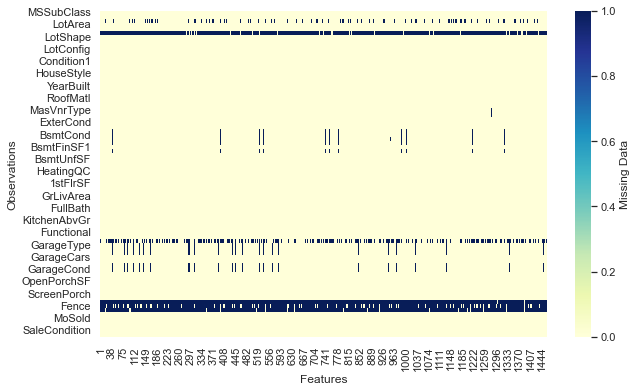

Those columns have missing values in those count and proportions:
  - LotFrontage: 259 (17.74%)
  - Alley: 1369 (93.77%)
  - MasVnrType: 8 (0.55%)
  - MasVnrArea: 8 (0.55%)
  - BsmtQual: 37 (2.53%)
  - BsmtCond: 37 (2.53%)
  - BsmtExposure: 38 (2.60%)
  - BsmtFinType1: 37 (2.53%)
  - BsmtFinType2: 38 (2.60%)
  - Electrical: 1 (0.07%)
  - FireplaceQu: 690 (47.26%)
  - GarageType: 81 (5.55%)
  - GarageYrBlt: 81 (5.55%)
  - GarageFinish: 81 (5.55%)
  - GarageQual: 81 (5.55%)
  - GarageCond: 81 (5.55%)
  - PoolQC: 1453 (99.52%)
  - Fence: 1179 (80.75%)
  - MiscFeature: 1406 (96.30%)


In [10]:
df = identify_missing_val(df)

**Takeaway:** Having confirmed our observation in the initial diagnostics, the difference across the different varibles would require an adapted cleaning process attending to each column or group of similar columns.

As per the data dictionary, **LotFrontage**  is the linear feet of street connected to property and indicates the measurement of a piece of land (lot) defined by frontage and depth respectively. For instance, an house can be 50 by 150, meaning 50 feet wide (frontage) and 150 feet long. Read more about it [here](https://www.gimme-shelter.com/frontage-50043/). Given that 'LotFrontage' is one of those characteristics all houses have, the null values indicate missing information that cannot just be equal to 0. Since we cannot go out and collect more data, we will investigate differences in distribution across Lot shape.

In [11]:
print("For all houses' LotFrontage, mean = {:.2f} and median = {:.2f}".format(df['LotFrontage'].mean(),
                                                                            df['LotFrontage'].median()))

print("For houses of shape: ")
for i in df["LotShape"].unique().tolist():
    df_i = df[df["LotShape"]==i]
    mean_frontage = df_i['LotFrontage'].mean()
    median_frontage = df_i['LotFrontage'].median()
    print(" -{}, mean LotFrontage = {:.2f} and median LotFrontage = {:.2f}".format(i,
                                                                            mean_frontage,
                                                                            median_frontage))

For all houses' LotFrontage, mean = 70.05 and median = 69.00
For houses of shape: 
 -Reg, mean LotFrontage = 67.04 and median LotFrontage = 67.00
 -IR1, mean LotFrontage = 76.09 and median LotFrontage = 74.00
 -IR2, mean LotFrontage = 76.50 and median LotFrontage = 57.50
 -IR3, mean LotFrontage = 138.43 and median LotFrontage = 150.00


**Takeaway:** 
- We observe a notable difference in houses categorized as IR3 (very irregular shape) thus, the imputation on LotFrontage will be done using median value grouped by 'LotShape' to ensure consistency in the data.

- For the other columns with missing information, the missing values refers the abscence of certain ameneties in agiven home. So, we will replace those with a seperate category as "No X Amenity"

- Such as in the instance of "Eletrical", we will just delete the observation(s) with the non-menaningful null values.

In [13]:
def missing_value_fix(data, rep):
    data.dropna(subset=['Electrical'], inplace=True)
    data['LotFrontage'] = data.groupby('LotShape').LotFrontage.transform(lambda x: x.fillna(x.median()))

    # Grouping of variables dependent on the presence of other amenities
    for i, j in rep.items():
        data[j].fillna(i, inplace = True)
        if i in ['Unknown', 'No Basement', 'No Garage', 0]:
            for col in j:
                data[col].fillna(i, inplace = True)

    ## No. of null values
    null_vals = data.isna().sum().sum()

    # Reporting back
    print("Afer imputation, we have missing {:d} values in our data.".format(null_vals))
        
    return data

rep = {
    'No Alley' : 'Alley',
    'No Fireplace' : 'FireplaceQu',
    'No Pool' : 'PoolQC',
    'No Fence' : 'Fence',
    'No Misc' : 'MiscFeature',

    'Unknown' : [
        'MSZoning', 'Utilities', 'Exterior1st', 
        'Exterior2nd', 'MasVnrType', 'KitchenQual',
        'Functional', 'SaleType',
    ],

    'No Basement' : [
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 
        'BsmtFinType1', 'BsmtFinType2', 
    ],

    'No Garage' : [
        'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond',
    ],

    0 : [
        'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
        'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
        'BsmtHalfBath', 'GarageCars', 
        #'GarageYrBlt',
        'GarageArea',
    ]
    }

df = missing_value_fix(df, rep)
df.head()

Afer imputation, we have missing 81 values in our data.


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,target
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,No Alley,Reg,Lvl,AllPub,Inside,...,0,No Pool,No Fence,No Misc,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,No Alley,Reg,Lvl,AllPub,FR2,...,0,No Pool,No Fence,No Misc,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,No Alley,IR1,Lvl,AllPub,Inside,...,0,No Pool,No Fence,No Misc,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,No Alley,IR1,Lvl,AllPub,Corner,...,0,No Pool,No Fence,No Misc,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,No Alley,IR1,Lvl,AllPub,FR2,...,0,No Pool,No Fence,No Misc,0,12,2008,WD,Normal,250000


In [14]:
# Detecting outliers using z-score
def outliers_detection(data, threshold=3):
    """ Function to detect outliers
    
    Parameters
    ----------
    data : dataframe
        A dataset
    threshold:
        The threshold at which a value is an outlier
        ±2.5σ from the µ

    Returns
    -------
    data
        a dataframe with no missing values 
        either after imputation or original format
    """
    print("At ±", threshold, "standard deviation from the mean:")
    for col in data.columns[:-1]:
        if data[col].dtype.kind in 'iufc':
            # Calculating the z-score for each predictor
            var = data[col]
            z = np.abs(stats.zscore(var))

            # Outlier
            pos = list(np.where(z > threshold)[0])
            no_of_outliers = len(pos)
            if no_of_outliers > 0:
                print("\t- ", col, "variable contains", no_of_outliers,  "outliers")
        else:
            continue

In [15]:
outliers_detection(df)

At ± 3 standard deviation from the mean:
	-  MSSubClass variable contains 30 outliers
	-  LotFrontage variable contains 18 outliers
	-  LotArea variable contains 13 outliers
	-  OverallQual variable contains 2 outliers
	-  OverallCond variable contains 28 outliers
	-  YearBuilt variable contains 6 outliers
	-  MasVnrArea variable contains 32 outliers
	-  BsmtFinSF1 variable contains 6 outliers
	-  BsmtFinSF2 variable contains 50 outliers
	-  BsmtUnfSF variable contains 11 outliers
	-  TotalBsmtSF variable contains 10 outliers
	-  1stFlrSF variable contains 12 outliers
	-  2ndFlrSF variable contains 4 outliers
	-  LowQualFinSF variable contains 20 outliers
	-  GrLivArea variable contains 16 outliers
	-  BsmtFullBath variable contains 16 outliers
	-  BsmtHalfBath variable contains 82 outliers
	-  HalfBath variable contains 12 outliers
	-  BedroomAbvGr variable contains 14 outliers
	-  KitchenAbvGr variable contains 68 outliers
	-  TotRmsAbvGrd variable contains 12 outliers
	-  Fireplaces

**Takeaway:** As we thought about handling those outliers, we decided to keep them all since ggood data science practices advocates to conserve as many data points as possible. Thus, allowing us to limit the biases simply to produce a better fitting model or statistically significant results.

# 4. Inquiry Exploration

In this section, we will generate various questions to further consolidate our understanding of the problem at hand. It will allow us to guide the machine learning process more attuned to the particular subject matter.

## Do bigger houses always translate into higher prices?

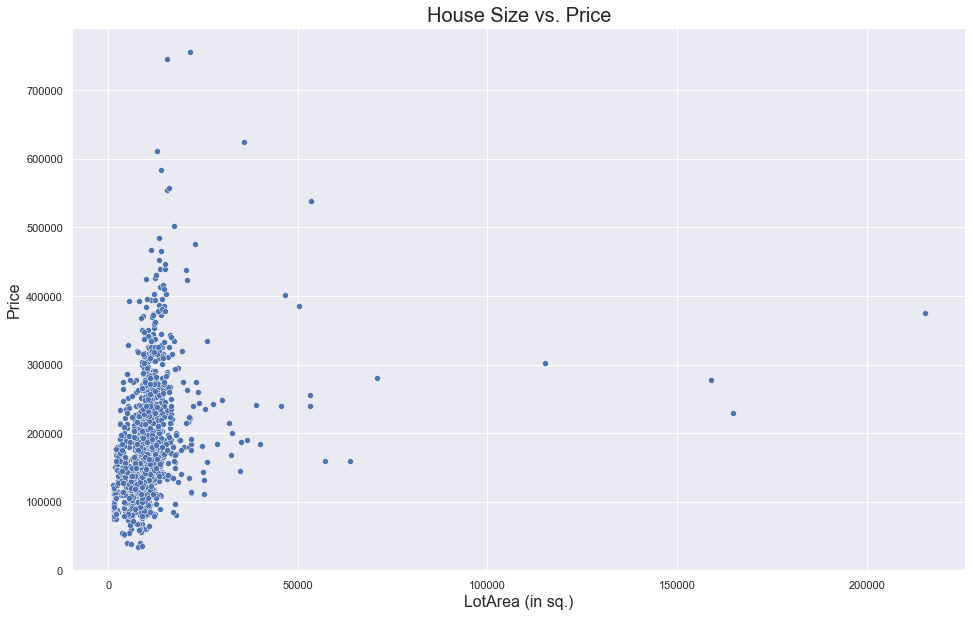

In [16]:
## Scatterplot between lotArea and SalePrice
sns.scatterplot(data=df, x='LotArea', y='target')
plt.xlabel('LotArea (in sq.)', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.title("House Size vs. Price", fontsize=20)
plt.show()

**Takeaway:** From the scatterplot above, there is very little evidence indicating that bigger houses are ultimiately pricier. As noted in the diagnostics, the 80 initial variables show how the house valuation process is multi-dimensional.

## Where is the real estate hotspot?

In [17]:
# Which neighborhood registers the most sales?
total = df['Neighborhood'].value_counts()[0]
per = df['Neighborhood'].value_counts(normalize=True)[0]
neigh_name = pd.DataFrame(df['Neighborhood'].value_counts()).index[0]
print("{} has the most houses sales with {} making up {:.2%} of all sales.".format(neigh_name, 
                                                                                  total, per))

# Which neighborhood registers the sales with the highest price tags?
df_grouped = pd.DataFrame(df.groupby('Neighborhood')['target'].sum())
df_sorted = df_grouped.sort_values('target', ascending=False)
df_sorted['per_total'] = (df_sorted['target'] / df_sorted['target'].sum())

neigh_name = df_sorted.index[0]
total = df_sorted['target'][0]
per = df_sorted['per_total'][0]
print("{} has the highest cumulative sales amount of ${:,} making up {:.2%} of all transactions.".format(
                                                                                                    neigh_name, 
                                                                                                    total, per))

NAmes has the most houses sales with 225 making up 15.42% of all sales.
NAmes has the highest cumulative sales amount of $32,815,593 making up 12.43% of all transactions.


**Note:** As per the data dictionary, NAmes refers to Iowan city of North Ames. 

## What miscellaneous feature add the most value?

In [18]:
# Which miscellaneous feature is the most prevalent?
total = df['MiscFeature'].value_counts()[1]
misc_name = pd.DataFrame(df['MiscFeature'].value_counts()).index[1]
print("For houses with miscellaneous features, {} is the most prevalent in {} houses.".format(misc_name, total))

# Calculating the value added
misc = df[df['MiscFeature'] == 'Shed']['MiscVal']
sale = df[df['MiscFeature'] == 'Shed']['target']
avg_value_added = np.average(misc)
per_sale = np.average(misc/sale)
print("{} brings ${:.2f} of value added making {:.2%} of the house sale price on average.".format(
                                                                                                misc_name, 
                                                                                                avg_value_added,
                                                                                                per_sale))

For houses with miscellaneous features, Shed is the most prevalent in 49 houses.
Shed brings $697.84 of value added making 0.48% of the house sale price on average.


# 5. Feature Engineering

## Datetime Variables: 

There are variables denoting dates and thus, may hold significance and impact our target variable: the house's sale price. 

Based on research, we thought that the most sensible option would be to transform the datetime variables into ordinal categories in twofold:
 - Direct encoding of 'MoSold' and 'YrSold' having 12 and 5 pre-defined categories that are the 12 months and 5 years respectively during which the houses in the dataset were sold.
 - Binning of 'YearRemodAdd' and 'YearBuilt' into 6 categories of 10 and 20 years of interval respectively before proceding to ordinal encoding as well.

In [19]:
## Categorical Encoding
def datetime_encoding(df, cols, mapping):
    """ Creating time intervals
    """
    # Slicing time into intervals
    for c in cols:
        df[c].fillna(0, inplace = True)
        df[c] = df[c].apply(lambda x: 2010 if x > 2010 else x)
        df[c] = pd.cut(df[df[c] != 0][c], bins=6, precision=0).astype(str)
        
    # Ordinal - Applying Ordinal encoder 
    enc_ord = ce.OrdinalEncoder(mapping = mapping, return_df = True)
    df_final = enc_ord.fit_transform(df)
    
    return df_final

In [20]:
date_cols_mapping = [ 
    {"col" : 'YrSold', "mapping": {2006:0, 2007: 1, 2008:2, 
                                   2009:3, 2010:4}},
    
    {"col" : 'MoSold', "mapping": {1: 0, 2: 1, 3:2, 4:3, 5:4, 6:5, 7:6, 
                                   8:7, 9:8, 10:9, 11:10, 12:11}},
    
    {"col" : 'YearRemodAdd', "mapping": {'(1950.0, 1960.0]':0, '(1960.0, 1970.0]':1,
                                         '(1970.0, 1980.0]':2, '(1980.0, 1990.0]':3,
                                         '(1990.0, 2000.0]':4, '(2000.0, 2010.0]':5}},
    
    {"col" : 'YearBuilt', "mapping": {'(1872.0, 1895.0]':0, '(1895.0, 1918.0]':1,
                                         '(1918.0, 1941.0]':2, '(1941.0, 1964.0]':3,
                                         '(1964.0, 1987.0]':4, '(1987.0, 2010.0]':5}},
    
    {"col" : 'GarageYrBlt', "mapping": {0:0, '(1900.0, 1918.0]':1,
                                        '(1918.0, 1937.0]':2, '(1937.0, 1955.0]':3,
                                        '(1955.0, 1973.0]':4, '(1973.0, 1992.0]':5,
                                        '(1992.0, 2010.0]':6}},
]

cols = ['YearRemodAdd', 'YearBuilt', 'GarageYrBlt']
df = datetime_encoding(df, cols, date_cols_mapping)

check_cols = ['YrSold', 'MoSold', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt']
df[check_cols].head()

,YrSold,MoSold,YearRemodAdd,YearBuilt,GarageYrBlt
Id,,,,,
1,2,1,5,5,6.0
2,1,4,2,4,5.0
3,2,8,5,5,6.0
4,0,1,1,1,6.0
5,2,11,4,5,6.0


In [21]:
## No. of null values
null_vals = df.isna().sum().sum()

# Reporting back
print("Afer imputation, we have missing {:d} values in our data.".format(null_vals))

Afer imputation, we have missing 0 values in our data.


## Categorical feature encoding

It ensures that variables with categories/groupings are transformed into numerical inputs for the predictive modeling phase. The categorical variables are also subdivided as:
- binary (two possible outcomes)
- cardinal (no meaningful order) 
- ordinal (meaningful order) 

Read more [here](https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/).

In [22]:
## Categorical Encoding
def categorical_encoding(df, binary_vars, nominal_vars, ordinal_cols_mapping):
    """ Function encoding  categorical variables
    
    Parameters
    ----------
    data : dataframe
        A dataset
        
    binary_vars, nominal_vars:
        List of binary and nominal categorical variables, respectively
    
    ordinal_cols_mapping:
        List of dictionary mapping the corresponding order of each category

    Returns
    -------
    data_encoded
        a dataframe with all categorical encoding transfomation
    """

    # Binary - Applying binary encoder
    binenc = ce.BinaryEncoder(cols = binary_vars, return_df = True)
    df = binenc.fit_transform(df)  
    
    # Nominal - Applying One-Hot encoder 
    for c in nominal_vars:
        df[c] = df[c].astype("category")
        df[c] = df[c].cat.codes

    # Ordinal - Applying Ordinal encoder 
    ordenc = ce.OrdinalEncoder(mapping = ordinal_cols_mapping, return_df = True)
    df_final = ordenc.fit_transform(df)  
    
    return df_final

In [23]:
# Encoding all categorical variables
bins = ['CentralAir']

noms = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotConfig', 
        'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
        'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 
        'Functional', 'GarageType', 'MiscFeature', 'SaleType', 
        'SaleCondition', 'Electrical']

# Encoding cardinal categorical variables
cat_ord_mapping = [ 
    {"col" : 'LotShape', "mapping": {'Reg':0, 'IR1': 1, 'IR2':2, 'IR3':3}},
    {"col" : 'LandContour', "mapping": {'Low':0, 'Lvl':1, 'Bnk':2, 'HLS':3}},
    {"col" : 'Utilities', "mapping": {'ELO':0, 'NoSeWa':1, 'NoSewr':2, 'AllPub':3}},
    {"col" : 'LandSlope', "mapping": {'Gtl': 0, 'Mod': 1, 'Sev':2}},
    {"col" : 'OverallQual', "mapping": {1: 0, 2: 1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 10:9}},
    {"col" : 'OverallCond', "mapping": {1: 0, 2: 1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 10:9}},
    {"col" : 'ExterQual', "mapping": {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}},
    {"col" : 'ExterCond', "mapping": {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}},
    {"col" : 'BsmtQual', "mapping": {'No Basement':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
    {"col" : 'BsmtCond', "mapping": {'No Basement':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},   
    {"col" : 'BsmtExposure', "mapping": {'No Basement':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}},
    {"col" : 'BsmtFinType1', "mapping": {'No Basement':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}}, 
    {"col" : 'BsmtFinType2', "mapping": {'No Basement':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}},  
    {"col" : 'HeatingQC', "mapping": {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}},
    {"col" : 'KitchenQual', "mapping": {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}},
    {"col" : 'FireplaceQu', "mapping": {'No Fireplace':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
    {"col" : 'GarageFinish', "mapping": {'No Garage':0, 'Unf':1, 'RFn':2, 'Fin':3}},
    {"col" : 'GarageQual', "mapping": {'No Garage':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
    {"col" : 'GarageCond', "mapping": {'No Garage':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
    {"col" : 'PavedDrive', "mapping": {'N':0, 'P':1, 'Y':2}}, 
    {"col" : 'PoolQC', "mapping": {'No Pool':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
    {"col" : 'Fence', "mapping":{'No Fence':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}}
]

df = categorical_encoding(df, binary_vars=bins, nominal_vars=noms, ordinal_cols_mapping=cat_ord_mapping)
df.head()

,MSSubClass_60.0,MSSubClass_20.0,MSSubClass_70.0,MSSubClass_50.0,MSSubClass_190.0,MSSubClass_45.0,MSSubClass_90.0,MSSubClass_120.0,MSSubClass_30.0,MSSubClass_85.0,...,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,target
Id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,208500
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,181500
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,223500
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,140000
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,250000


## Feature Scaling:

When dealing with data, we are working with different types of which required adpated pre-processing before applying any machine learning techniques. In our content, we perform feature scaling to standardize only the values in continuous numerical variables. Read more [here](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35).

In [24]:
def feature_scaling(data, cont_vars): 
    """ Function standardizing numerical variable of different scales
    
    Parameters
    ----------
    data : dataframe
        A dataset
        
    Returns
    -------
    data
        A standardized dataframe
    """
    scaler = MinMaxScaler()
    for col in cont_vars:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

In [25]:
# Numeric columns
num_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
           'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
            'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

df = feature_scaling(df, num_vars)
df[num_vars].head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
Id,,,,,,,,,,,,,,,,,,,
1,0.150685,0.033420,0.12250,0.125089,0.0,0.064212,0.140098,0.119780,0.413559,0.0,0.259231,0.386460,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0
2,0.202055,0.038795,0.00000,0.173281,0.0,0.121575,0.206547,0.212942,0.000000,0.0,0.174830,0.324401,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.160959,0.046507,0.10125,0.086109,0.0,0.185788,0.150573,0.134465,0.419370,0.0,0.273549,0.428773,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0
4,0.133562,0.038561,0.00000,0.038271,0.0,0.231164,0.123732,0.143873,0.366102,0.0,0.260550,0.452750,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0
5,0.215753,0.060576,0.21875,0.116052,0.0,0.209760,0.187398,0.186095,0.509927,0.0,0.351168,0.589563,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.0


# 4. Correlation Analysis

**Note:** Given that we have 240 columns, it would be quite computationally intensive to display the entire correlation matrix and visualize it for user-friendly analysis. As a result, we will only filter out relatively and highly correlated relationship with coefficient between 0.7 and 1 (non-inclusive to avoid pairs of identical variables).

In [26]:
## Strongest Relationships
matrix_corr = df.corr()
matrix_corr = np.round(matrix_corr.unstack(), 2)
strong_rel = matrix_corr[(abs(matrix_corr) >= 0.75) & (abs(matrix_corr) != 1.00)]
strong_rel

MSSubClass_60.0        HouseStyle_2Story        0.76
MSSubClass_20.0        HouseStyle_1Story        0.76
MSSubClass_50.0        HouseStyle_1.5Fin        0.94
MSSubClass_190.0       BldgType_2fmCon          0.98
MSSubClass_45.0        HouseStyle_1.5Unf        0.93
                                                ... 
SaleType_New           SaleType_WD             -0.77
                       SaleCondition_Partial    0.99
SaleCondition_Partial  SaleType_WD             -0.77
                       SaleType_New             0.99
target                 OverallQual              0.79
Length: 84, dtype: float64

**Takeaway:** We detected 98 relationships of which we assume 40 to be unique pairs having a correlation coefficients greather than 0.75. Given that our focus is on the sale of the house, we will filter out only relationships related to variables with 'Sale' as a prefix.

In [27]:
# Focus on variables directly related to the sale
matrix_corr = df.corr()
matrix_sale = matrix_corr.filter(regex='^Sale',axis=1)
matrix_sale = np.round(matrix_sale.unstack(), 2)
strong_rel_sale = matrix_sale[(abs(matrix_sale) >= 0.75) & (abs(matrix_sale) != 1.00)]
strong_rel_sale

SaleType_WD            SaleType_New            -0.77
                       SaleCondition_Partial   -0.77
SaleType_New           SaleType_WD             -0.77
                       SaleCondition_Partial    0.99
SaleCondition_Partial  SaleType_WD             -0.77
                       SaleType_New             0.99
dtype: float64

**Takeaway:** Among the two detected, 'OverallQual' appears to be a key variable that is highly correlated to the sale price of the house. It probably falls inline with our expectations in terms of the valuation process of a house; indeed, it requires good to excellent quality to be desired on the real estate market.

# 7. Machine Learning set-up

Under this section, we will explain the procedure of two main splitting approach to estimate our models' performance. 

**Model Selection methods:** 
* **Train_test_split**: Often denoted as the most popular by its simplicity, the train-test split is a sampling technique dividing the dataset between training and testing sets. In doing so, the goal would be to have enough (but not too much) in our training set used for the machine learning model to predict the observations in the testing set as accurately as possible. Most would opt for a 70/30 training-testing split, respectively, others 80/20, 60/40, or whichever else works best for the case scenario. Further information [here](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/). 

* **Cross-validation**: As the name would suggest, we will engage here in the process of validation to ensure reliability on our model. Cross-Validation is a statistical method applied in various ways to estimate the model's performance. Some examples are **Holdout Method, K-Fold, Stratified K-Fold, Leave-P-Out.**  Further information [here](https://machinelearningmastery.com/k-fold-cross-validation/) and [here](https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f).

In [28]:
def model_comparison(df, models, metric='neg_mean_squared_log_error'):
    """ Function to split data into training and testing set
    
    Parameters
    ----------
    data : dataframe
        A dataset
    models: A dictionary
        A pre-defined dictionary with each model name and applicable function
    
    optional train_test params
    
    Returns
    -------
    models_df
        A dataframe with each model performance
    """
    
    # Splitting features & target variable
    X = df.drop(columns=['target'], axis=1)
    y = df['target']
    
    # Obtain training and testing sets from function above
    #X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # Craete dictionary to save performance data 
    models_perf = {'Models': [], 'CV_RMSLE_mean': [], 'CV_RMSLE_std': []}
    
    # Obtain model performance across K-Fold using Cross-Validation 
    for model in models:
        cv_results = cross_validate(model, X, y, 
                                    cv=5, scoring=metric)
        cv_rmsle = np.sqrt(abs(cv_results['test_score']))
        m = str(model)
        models_perf['Models'].append(m[:m.find("(")])
        models_perf['CV_RMSLE_mean'].append(np.mean(cv_rmsle))
        models_perf['CV_RMSLE_std'].append(np.std(cv_rmsle))
    
    
    models_df = pd.DataFrame(models_perf, columns = ['Models', 'CV_RMSLE_mean', 'CV_RMSLE_std'])
    return models_df

# 8. Machine Learning - Model Building

* **Simple Methods:** We will leverage the powerful sci-kit-learn package to build multiple models with little to no parameter tuning for comparison. We will only use the cross-validation error on our training dataset to avoid any data leakage.

* **Ensemble Methods:** We will extend our work in machine learning to incorporate ensemble methods. We generated simple models and compared the scores, which appear satisfactory; however, we may want more stability and minor variation in our predictive algorithm; it is where ensemble techniques come in. Most often, they act as a 'superposer' of multiple models throughout various ways and thus, bolster their predictive power. Further Information [here](https://machinelearningmastery.com/tour-of-ensemble-learning-algorithms/). 

In [29]:
# Simple ML Models
models_simple = [DecisionTreeRegressor(), 
                 SGDRegressor(), SVR()]

# Model Comparison
model_comparison(df, models_simple)

,Models,CV_RMSLE_mean,CV_RMSLE_std
0,DecisionTreeRegressor(),0.212169,0.011754
1,SGDRegressor(),0.189654,0.038622
2,SVR(),0.399590,0.016330


In [30]:
# List of ML ensemble models
models_ensemble = [RandomForestRegressor(), BaggingRegressor(),
                   GradientBoostingRegressor()]

# Model Comparison
model_comparison(df, models_ensemble)

,Models,CV_RMSLE_mean,CV_RMSLE_std
0,RandomForestRegressor(),0.146002,0.006807
1,BaggingRegressor(),0.149732,0.005203
2,GradientBoostingRegressor(),0.129260,0.008513


**Takeaway:** In comparing the simple and ensemble models, we shall evaluate both the mean for the performance across the K-folds and standard deviation for model stability. In that regard, the best model comes out to be the GradientBoostingRegressor().

# 9. Hyperparameter Tuning

This section will walk through a process to find the best possible models given a set of parameters. In machine learning, we name it hyperparameter tuning during which the algorithm search for the set of optimal hyperarameters driving the metric as high (or low depending the case scenario) as possible. Further information [here](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/). 

In [31]:
def hyperparameter_tuning(data, model, search_space, metric='neg_mean_squared_log_error'):
    """ Conduct hyperparameter tuning using GridSearch
    
    Parameters
    ----------
    data : dataframe
        Dataset
    model: Model function
        Corresponding function in Sklearn
    search_space: A dictionary
        Possible values for each parameter to iterate
    metric: String
        Evaluation metric name per Scikit-learn documentation
    
    Returns
    -------
    models_df
        A
    """
    # Splitting features & target variable
    X = df.drop(columns=['target'], axis=1)
    y = df['target']
    
    # Obtain training and testing sets from function above
    #X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # Running the search
    search = GridSearchCV(estimator=model, param_grid=search_space, 
                          cv=5, scoring=metric, refit=metric)
    
    # Fit the GridSearchCV
    search.fit(X, y)
    best_score = np.sqrt(abs(search.best_score_))
    scores_std = np.average(search.cv_results_['std_test_score'])
    
    print('Optimal {} averaged {:.4f} RMSLE with {:.4f} std. with params: {}'.format(str(model), 
                                                                                 best_score, scores_std, 
                                                                                 search.best_params_))
    
    return search

In [32]:
# Define the searching space
model_space = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [2, 3, 4, 5, 6]
}

start = time.time()
# Finding the best model
tuning_func = hyperparameter_tuning(df, model = GradientBoostingRegressor(), 
                                    search_space = model_space)
end = time.time()

Optimal GradientBoostingRegressor() averaged 0.1258 RMSLE with 0.0027 std. with params: {'max_depth': 3, 'n_estimators': 250}


In [33]:
lapse = end - start
print("Hyperparameter Tuning took ~ %.2f mins" % (lapse/60))

Hyperparameter Tuning took ~ 6.23 mins


# 10. Final Submission

In [34]:
# Loading the dataset
#df_train = df
df_test = pd.read_csv("/Users/Graduate/Desktop/ds_proj_data/house_price/test.csv")
df_test.set_index('Id', inplace=True)
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [35]:
## Categorical Encoding
def datetime_encoding(df, cols, mapping):
    """ Creating time intervals
    """
    # Slicing time into intervals
    for c in cols:
        df[c] = df[c].apply(lambda x: 2010 if x > 2010 else x)
        df[c].fillna(0, inplace = True)
        df[c] = pd.cut(df[df[c] != 0][c], bins=6, precision=0).astype(str)
        
        
    #Ordinal - Applying Ordinal encoder 
    enc_ord = ce.OrdinalEncoder(mapping = mapping, return_df = True)
    df_final = enc_ord.fit_transform(df)
    
    return df_final


test_date_cols_mapping = [ 
    {"col" : 'YrSold', "mapping": {2006:0, 2007: 1, 2008:2, 
                                   2009:3, 2010:4}},
    
    {"col" : 'MoSold', "mapping": {1: 0, 2: 1, 3:2, 4:3, 5:4, 6:5, 7:6, 
                                   8:7, 9:8, 10:9, 11:10, 12:11}},
    
    {"col" : 'YearRemodAdd', "mapping": {'(1950.0, 1960.0]':0, '(1960.0, 1970.0]':1,
                                         '(1970.0, 1980.0]':2, '(1980.0, 1990.0]':3,
                                         '(1990.0, 2000.0]':4, '(2000.0, 2010.0]':5}},
    
    {"col" : 'YearBuilt', "mapping": {'(1879.0, 1901.0]':0, '(1901.0, 1923.0]':1,
                                      '(1923.0, 1944.0]':2, '(1944.0, 1966.0]':3,
                                      '(1966.0, 1988.0]':4, '(1988.0, 2010.0]':5}},
    
    {"col" : 'GarageYrBlt', "mapping": {0:0, '(1895.0, 1914.0]':1,
                                        '(1914.0, 1933.0]':2, '(1933.0, 1952.0]':3,
                                        '(1952.0, 1972.0]':4, '(1972.0, 1991.0]':5,
                                        '(1991.0, 2010.0]':6}},
]

cols = ['YearRemodAdd', 'YearBuilt', 'GarageYrBlt']
check_cols = ['YrSold', 'MoSold', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt']

In [36]:
df_test = datetime_encoding(df_test, cols, test_date_cols_mapping)
df_test = missing_value_fix(df_test, rep)
df_test = categorical_encoding(df_test, binary_vars=bins, nominal_vars=noms, 
                               ordinal_cols_mapping=cat_ord_mapping)
df_test = basic_processing(df_test)
df_test = feature_scaling(df_test, num_vars)
df_test.head()

Afer imputation, we have missing 0 values in our data.


,MSSubClass_20.0,MSSubClass_60.0,MSSubClass_120.0,MSSubClass_160.0,MSSubClass_80.0,MSSubClass_30.0,MSSubClass_50.0,MSSubClass_90.0,MSSubClass_85.0,MSSubClass_190.0,...,SaleType_ConLw,SaleType_ConLI,SaleType_CWD,SaleType_Unknown,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Alloca,SaleCondition_AdjLand
Id,,,,,,,,,,,,,,,,,,,,,
1461,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1462,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1463,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1464,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1465,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [37]:
# Splitting features & target variable
df_train = df
X = df_train.drop(columns=['target'], axis=1)
y = df_train['target']

In [38]:
# Matching columns
cols_rep = list(set(list(X.columns)) ^ set(list(df_test.columns)))
for col in list(df_test.columns):
    if col not in list(X.columns):
        X[col] = 0
        #print(X[col].head())
    else:
        continue
for col in list(X.columns):
    if col not in list(df_test.columns):
        df_test[col] = 0
    else:
        continue
df_test.shape, X.shape

((1459, 249), (1459, 249))

In [41]:
# Fitting best model
best_model =  GradientBoostingRegressor().set_params(**tuning_func.best_params_)
best_model.fit(X, y)

GradientBoostingRegressor(n_estimators=250)

In [52]:
## Final Predictions
y_pred = best_model.predict(df_test)
y_pred_df = pd.DataFrame(y_pred, columns=['SalePrice'])
y_pred_df.reset_index(inplace=True)
y_pred_df.rename(columns = {'index':'Id'}, inplace=True)
y_pred_df.head()

,Id,SalePrice
0,0,121492.131263
1,1,136462.780203
2,2,141903.275854
3,3,138882.801723
4,4,118538.330723


In [ ]:
#y_pred_df.to_csv('sample_submissions.csv')